#分類演習問題2

【目的】
* kaggleのタイタニックデータを使って、生存者の予測をする。

【データセット】
* 沈没した豪華客船タイタニック号に乗っていた人でどんな特徴を持っていた人が生存あるいは死亡したかというデータである。

* データはtrain.csvとtest.csvの2つ。train.csvで学習を行い、モデルをtest.csvに当てはめる。

* 目的変数はsurvivedの0あるいは1である。

【演習問題】
* 問題2-1
  * データをロードして、備考欄を参考にデータの欠損値を代表値で補完せよ。ただし、欠損値がデータ全体の半数以上を占める変数については、無視すること。

* 問題2-2 
  * ヒートマップを作成して、各変数ごとの相関を確認し、使用する説明変数を選択せよ。
　
* 問題2-3
  * 人が生存するかどうか分類せよ。このとき、欠損値がデータ全体の半分以上を占める変数は説明変数として使用しないこと。
  * 分類の際は、複数のモデルを試してみること。
  * 各モデル毎に正解率を確認すること。

【備考】
* 欠損値があるかどうかは、isnull()を使って確認できる。
* 欠損値を埋めるには、代表値（平均値、中央値、最頻値など）で埋める方法が簡潔であるが、参考までにk近傍法（クラスタリングのところで紹介している）で埋めるやり方もある。
* ヒートマップや変数選択などについては回帰でやった内容が参考になる。



データの変数の詳細は以下を参照


[変数の意味]



PassemgerID：乗客ID

survived：生存したかどうか　0…生存しなかった、1…生存した

pclass：チケットの階級,	1 = 1st, 2 = 2nd, 3 = 3rd

sex：性別

Age：年齢

sibsp：兄弟、配偶者の数

parch：両親、子供の数

ticket：チケットナンバー

fare：料金

cabin：部屋番号	

embarked：出港地	C = Cherbourg, Q = Queenstown, S = Southampton




#分類演習問題2解答

##問題2-1

###データの確認

* ライブラリのインポート

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


* ドライブをマウントしてデータをロードする

In [ ]:
# あらかじめドライブをマウント

! git clone https://github.com/dcs-aidojo/public-data.git

Cloning into 'public-data'...
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 227 (delta 0), reused 0 (delta 0), pack-reused 222
Receiving objects: 100% (227/227), 21.11 MiB | 16.07 MiB/s, done.
Resolving deltas: 100% (69/69), done.


* cloneしたデータの確認

In [ ]:
!ls
%cd public-data/
!ls

public-data  sample_data
/content/public-data
course_cloud		 README.md  weather201708.csv
course_library		 test.csv   weather201808.csv
jinkou_menseki_data.csv  train.csv  weather201908.csv


+ データフレームにする、中身確認

In [ ]:
train_df = pd.read_csv('train.csv')
print(train_df.head(10))
test_df = pd.read_csv('test.csv')
print(test_df.head(10))

   PassengerId  Survived  Pclass  ...     Fare Cabin  Embarked
0            1         0       3  ...   7.2500   NaN         S
1            2         1       1  ...  71.2833   C85         C
2            3         1       3  ...   7.9250   NaN         S
3            4         1       1  ...  53.1000  C123         S
4            5         0       3  ...   8.0500   NaN         S
5            6         0       3  ...   8.4583   NaN         Q
6            7         0       1  ...  51.8625   E46         S
7            8         0       3  ...  21.0750   NaN         S
8            9         1       3  ...  11.1333   NaN         S
9           10         1       2  ...  30.0708   NaN         C

[10 rows x 12 columns]
   PassengerId  Pclass  ... Cabin Embarked
0          892       3  ...   NaN        Q
1          893       3  ...   NaN        S
2          894       2  ...   NaN        Q
3          895       3  ...   NaN        S
4          896       3  ...   NaN        S
5          897       3  .

* トレーニングデータの統計量を見る

In [ ]:
# トレーニングデータの統計
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


* テストデータの統計量を見る

In [ ]:
# テストデータの統計
test_df.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


* データ数、カラム数の確認

In [ ]:
train_shape = train_df.shape
test_shape = test_df.shape

print(train_shape)
print(test_shape)

(891, 12)
(418, 11)


* 欠損値の確認（トレーニングデータ）

In [ ]:
# train_dfの欠損値
null = train_df.isnull().sum()
percent = train_df.isnull().sum()*100/len(train_df)
table = pd.concat([null, percent], axis=1)
table = table.rename(columns = {0 : '欠損してる数', 1 : '%'})
print(table)

             欠損してる数          %
PassengerId       0   0.000000
Survived          0   0.000000
Pclass            0   0.000000
Name              0   0.000000
Sex               0   0.000000
Age             177  19.865320
SibSp             0   0.000000
Parch             0   0.000000
Ticket            0   0.000000
Fare              0   0.000000
Cabin           687  77.104377
Embarked          2   0.224467


* 欠損値の確認（テストデータ）

In [ ]:
# test_dfの欠損値
null = test_df.isnull().sum()
percent = test_df.isnull().sum()*100/len(test_df)
table = pd.concat([null, percent], axis=1)
table = table.rename(columns = {0 : '欠損してる数', 1 : '%'})
print(table)

             欠損してる数          %
PassengerId       0   0.000000
Pclass            0   0.000000
Name              0   0.000000
Sex               0   0.000000
Age              86  20.574163
SibSp             0   0.000000
Parch             0   0.000000
Ticket            0   0.000000
Fare              1   0.239234
Cabin           327  78.229665
Embarked          0   0.000000


* ここまででAge, Fare, cabin, embarkedに欠損値があることが分かる

+ Ageの分布を確認するため、ヒストグラムを表示する。

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([40., 14., 15., 31., 79., 98., 85., 84., 73., 45., 35., 35., 29.,
        16., 13., 11.,  4.,  5.,  1.,  1.]),
 array([ 0.42 ,  4.399,  8.378, 12.357, 16.336, 20.315, 24.294, 28.273,
        32.252, 36.231, 40.21 , 44.189, 48.168, 52.147, 56.126, 60.105,
        64.084, 68.063, 72.042, 76.021, 80.   ]),
 <a list of 20 Patch objects>)

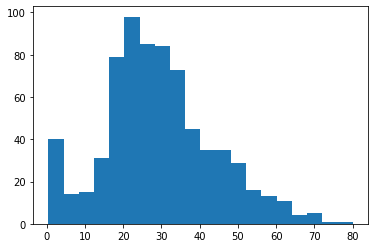

In [ ]:
plt.hist(train_df["Age"], bins=20)

+ Fareの分布を確認するため、ヒストグラムを表示する。

(array([337., 182., 147.,  50.,  16.,  39.,  18.,  29.,  18.,   2.,   8.,
          7.,   0.,   7.,   9.,   0.,   2.,   0.,   0.,   0.,   4.,   1.,
          4.,   0.,   2.,   6.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   3.]),
 array([  0.      ,  10.246584,  20.493168,  30.739752,  40.986336,
         51.23292 ,  61.479504,  71.726088,  81.972672,  92.219256,
        102.46584 , 112.712424, 122.959008, 133.205592, 143.452176,
        153.69876 , 163.945344, 174.191928, 184.438512, 194.685096,
        204.93168 , 215.178264, 225.424848, 235.671432, 245.918016,
        256.1646  , 266.411184, 276.657768, 286.904352, 297.150936,
        307.39752 , 317.644104, 327.890688, 338.137272, 348.383856,
        358.63044 , 368.877024, 379.123608, 389.370192, 399.616776,
        409.86336 , 420.109944, 430.356528, 440.603112, 450.849696,
        461.09628 , 471.342864, 481.589448, 49

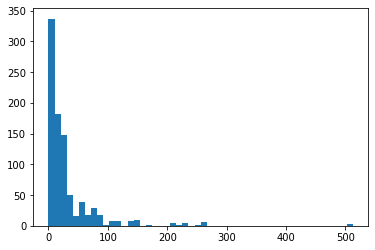

In [ ]:
plt.hist(train_df["Fare"], bins=50)

###欠損値を埋める

* ここではageとfareには中央値、embarkedには最頻値を代入する。
* ageは中央値、平均値、最頻値に差がほとんどないため、代表的な補完方法である中央値を代入している。
* fareはヒストグラムから、偏りが大きい分布をしていることが分かり、中央値で代入している。
* embarkedは、数値ではないため、最頻値「S」で埋める。
* cabinは欠損値が半分を超えていて統計データとして問題があるので使わない（列を削除する）。


In [ ]:
train_df["Age"] = train_df["Age"].fillna(train_df["Age"].median())
train_df["Embarked"] = train_df["Embarked"].fillna("S")
test_df["Age"] = test_df["Age"].fillna(test_df["Age"].median())
test_df["Embarked"] = test_df["Embarked"].fillna("S")
test_df.Fare[152] = test_df.Fare.median()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


###カテゴリ変数化

sexとEmbarkedを数値に変換する。カテゴリ変数化と呼ばれるが、この作業を行うことで分類や回帰の数式で使うことができる。

In [ ]:
train_df["Sex"] = train_df["Sex"].replace("male",0)
train_df["Sex"] = train_df["Sex"].replace("female",1)
train_df["Embarked"] = train_df["Embarked"].replace("S", 0)
train_df["Embarked"] = train_df["Embarked"].replace("C", 1)
train_df["Embarked"] = train_df["Embarked"].replace("Q", 2)


test_df["Sex"] = test_df["Sex"].replace("male",0)
test_df["Sex"] = test_df["Sex"].replace("female",1)
test_df["Embarked"] = test_df["Embarked"].replace("S", 0)
test_df["Embarked"] = test_df["Embarked"].replace("C", 1)
test_df["Embarked"] = test_df["Embarked"].replace("Q", 2)

##問題2-2

###ヒートマップの作成

In [ ]:
# train_dfの欠損値
null = train_df.isnull().sum()
percent = train_df.isnull().sum()*100/len(train_df)
table = pd.concat([null, percent], axis=1)
table = table.rename(columns = {0 : '欠損してる数', 1 : '%'})
print(table)

             欠損してる数          %
PassengerId       0   0.000000
Survived          0   0.000000
Pclass            0   0.000000
Name              0   0.000000
Sex               0   0.000000
Age               0   0.000000
SibSp             0   0.000000
Parch             0   0.000000
Ticket            0   0.000000
Fare              0   0.000000
Cabin           687  77.104377
Embarked          0   0.000000


* ヒートマップを作成して変数間の相関を確認する

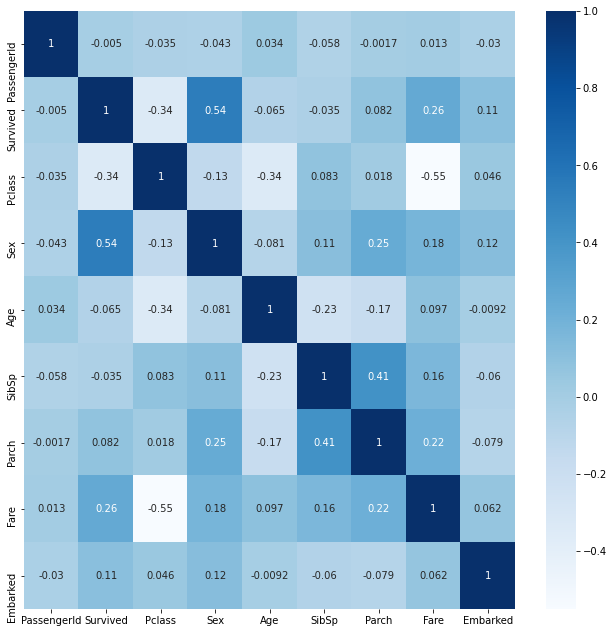

In [ ]:
plt.figure(figsize=(11,11))
sns.heatmap(train_df.corr(), annot=True, cmap='Blues')

* survivedと相関が大きい順にSex、Pclass、Fareとなる。 相関係数は絶対値が0.2未満であるとほとんど相関がないと言われるので、他の変数は今回使わないこととする。

* 今回、以下で記載するモデルには決定木とランダムフォレストを用いている

##問題2-3

###決定木

* 決定木の手法で分類する

In [ ]:
# いらない変数を削除
df = train_df.drop(['PassengerId', 'Age', 'SibSp', 'Embarked', 'Parch', 'Cabin', 'Name', 'PassengerId','Ticket'],axis=1)
train_X = df.drop('Survived', axis=1)
train_y = df.Survived
train_X, test_X ,train_y, test_y = train_test_split(train_X, train_y, test_size = 0.3)
print(df)
# 決定木の手法を使う
clf = DecisionTreeClassifier(random_state=0)
clf = clf.fit(train_X, train_y)
pred = clf.predict(test_X)


     Survived  Pclass  Sex     Fare
0           0       3    0   7.2500
1           1       1    1  71.2833
2           1       3    1   7.9250
3           1       1    1  53.1000
4           0       3    0   8.0500
..        ...     ...  ...      ...
886         0       2    0  13.0000
887         1       1    1  30.0000
888         0       3    1  23.4500
889         1       1    0  30.0000
890         0       3    0   7.7500

[891 rows x 4 columns]


* AUCを計算

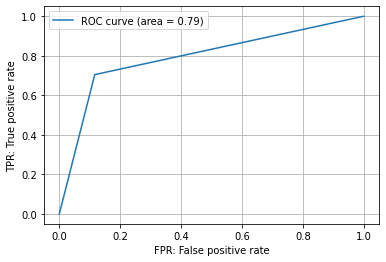

In [ ]:
# auc
fpr, tpr, thresholds = roc_curve(test_y, pred, pos_label=1)
auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc)
plt.legend()
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.grid()
plt.show()


* 一般にaucの値が0.7から0.9は適度な（moderate）精度と言われており、今回の分類結果はこれに該当する。

* 正解率を計算

In [ ]:
# 正解率
accuracy_score(pred, test_y)

0.8134328358208955

* (参考)適合率を計算


In [ ]:
# 適合率
precision_score(pred, test_y)

0.7047619047619048

###ランダムフォレスト

* ランダムフォレストの手法で分類する

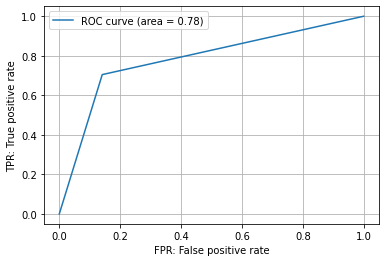

In [ ]:
# ランダムフォレストの手法を使う
clf2 = RandomForestClassifier(random_state=0)
clf2 = clf2.fit(train_X, train_y)
pred2 = clf2.predict(test_X)

# auc
fpr, tpr, thresholds = roc_curve(test_y, pred2, pos_label=1)

auc2 = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc2)
plt.legend()
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.grid()
plt.show()


* 正解率を計算する

In [ ]:
# 正解率
accuracy_score(pred2, test_y)

0.7985074626865671

* （参考）適合率を計算する

In [ ]:
# 適合率
precision_score(pred2, test_y)